# 模型选择、欠拟合和过拟合

通过多项式拟合来探索这些概念

In [11]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [12]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

查看一下前2个样本

In [13]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.4330],
         [-0.1752]]),
 tensor([[ 1.0000e+00,  1.4330e+00,  1.0268e+00,  4.9049e-01,  1.7572e-01,
           5.0364e-02,  1.2029e-02,  2.4626e-03,  4.4112e-04,  7.0239e-05,
           1.0066e-05,  1.3113e-06,  1.5660e-07,  1.7262e-08,  1.7670e-09,
           1.6881e-10,  1.5120e-11,  1.2745e-12,  1.0147e-13,  7.6532e-15],
         [ 1.0000e+00, -1.7516e-01,  1.5341e-02, -8.9573e-04,  3.9225e-05,
          -1.3742e-06,  4.0117e-08, -1.0039e-09,  2.1980e-11, -4.2779e-13,
           7.4932e-15, -1.1932e-16,  1.7417e-18, -2.3468e-20,  2.9363e-22,
          -3.4288e-24,  3.7538e-26, -3.8678e-28,  3.7639e-30, -3.4700e-32]]),
 tensor([6.0814, 4.7624]))

实现一个函数来评估模型在给定数据集上的损失

In [14]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [20]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # nn.Linear是全连接层,有三个参数:
    # input_shape:输入特征的维度
    # output_shape:输出特征的维度,这里设置为1,因为逻辑回归只有一个输出
    # bias:偏置参数,默认为True。如果设置为False,则该层不会有偏置参数b。
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正常)

weight: [[ 4.992467   1.2115057 -3.3801525  5.6007013]]


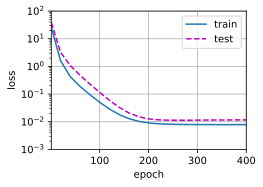

In [21]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[2.7912374 4.1564813]]


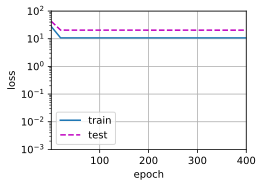

In [22]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.98674679e+00  1.29924810e+00 -3.33811140e+00  5.12747383e+00
  -1.39034107e-01  1.43867946e+00  1.03634626e-01  1.76101148e-01
   2.02669606e-01 -1.04521945e-01  3.25978845e-02 -1.91768393e-01
   1.02612391e-01 -1.57585740e-02  1.03789136e-01 -4.40739356e-02
   2.45312951e-03  5.62473722e-02 -1.10983565e-01  1.51725382e-01]]


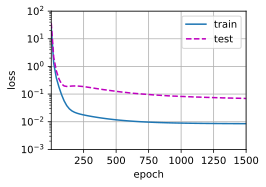

In [23]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)